In [1]:
import os
import sys
import gin
import numpy as np
import pandas as pd
sys.path.append('../')
from IPython.core.display import clear_output, display
from ariadne.graph_net.graph_utils.graph_prepare_utils import to_pandas_graph_from_df, get_pd_line_graph, \
    apply_nodes_restrictions, apply_edge_restriction, construct_output_graph

from ariadne.transformations import Compose, ConstraintsNormalize, ToCylindrical,DropFakes, DropSpinningTracks, DropShort
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
from ariadne.tracknet_v2.model import TrackNETv2
import torch

gin.bind_parameter('TrackNETv2.input_features', 3)
gin.bind_parameter('TrackNETv2.conv_features', 32)
gin.bind_parameter('TrackNETv2.rnn_type', 'gru')
gin.bind_parameter('TrackNETv2.batch_first', True)

def weights_update(model, checkpoint):
    model_dict = model.state_dict()    
    pretrained_dict =  checkpoint['state_dict']
    real_dict = {}
    for (k,v) in model_dict.items():
        needed_key = None
        for pretr_key in pretrained_dict:
            if k in pretr_key:
                needed_key = pretr_key
                break
        assert needed_key is not None, "key %s not in pretrained_dict %r!" % (k, pretrained_dict.keys())
        real_dict[k] = pretrained_dict[needed_key]

    model.load_state_dict(real_dict)
    model.eval()
    return model

model = weights_update(model=TrackNETv2(), checkpoint=torch.load('../lightning_logs/epoch=270.ckpt'))


In [3]:
from ariadne.tracknet_v2_1.model import Classifier
class_model = weights_update(model=Classifier(), checkpoint=torch.load('../lightning_logs/epoch=0.ckpt'))

In [4]:
#пропуск - это если у нас все побатчево

In [4]:
data = np.load('../output/cgem_t_plain_explicit_test/tracknet_test_all_explicit_1000_1300.npz')

In [5]:
import numpy as np
all_last_station_coordinates = np.load('../output/cgem_t_plain_explicit_test/tracknet_test_all_explicit_1000_1300_all_last_station.npz')
#y info
last_station_hits = all_last_station_coordinates['hits'][:, 1:]
last_station_hits_torch = torch.from_numpy(last_station_hits)
#events for all y
last_station_events = all_last_station_coordinates['event']
last_station_events_torch = torch.from_numpy(last_station_events)


In [6]:
last_station_events_torch

tensor([1000, 1000, 1000,  ..., 1299, 1299, 1299])

In [7]:
from copy import copy

In [8]:
from torch.nn import Softmax

In [9]:
from ariadne.tracknet_v2.metrics import point_in_ellipse
def find_nearest_hit(ellipses,hits):
    centers = ellipses[:,:2]
    dists = torch.cdist(hits.float(), centers.float())
    min_argument = torch.argmin(dists, dim=0)
    minimal = hits[torch.argmin(dists, dim=0)]
    is_in_ellipse = point_in_ellipse(ellipses, minimal)
    return minimal, is_in_ellipse

def handle_batch(batch_input, batch_target, batch_real_flag, all_last_y):   
    with torch.no_grad():
        test_pred = model(inputs=batch_input['inputs'], input_lengths=batch_input['input_lengths'])
        num_real_tracks = batch_real_flag.sum()
        nearest_points, is_point_in_ellipse = find_nearest_hit(test_pred, all_last_y)
        is_prediction_true = (batch_target == nearest_points)
        is_prediction_true = is_prediction_true.sum(axis=1) / 2
        found_points = nearest_points[(is_point_in_ellipse) & (batch_real_flag == 1)]
        found_nothing = nearest_points[(~is_point_in_ellipse) & (batch_real_flag == 1)]
        num_points_for_real_tracks = len(found_points)
        num_fales_for_real_tracks = len(found_nothing)
        is_relevant_prediction_true = is_prediction_true[(batch_real_flag == 1) & (is_point_in_ellipse)]
        print(is_relevant_prediction_true)
        if num_real_tracks > 0:
            batch_recall = is_relevant_prediction_true.sum() / float(num_real_tracks)
            batch_precision = is_relevant_prediction_true.sum() / float(num_points_for_real_tracks)
            batch_fale_rate = num_fales_for_real_tracks / float(num_real_tracks)
            print(batch_recall, batch_precision, batch_fale_rate )
            return batch_recall, batch_precision, batch_fale_rate
        else:
            return -1,-1,-1
            
def handle_batch_to_df(orig_batch, all_last_y):   
    with torch.no_grad():
        temp_dict = {}
        batch = copy(orig_batch)
        temp_df = pd.DataFrame(columns=['found_nothing', 'found_right_point','is_real_track', 'px','py','pz','p'])
        batch_input = batch['x']
        batch_real_flag = batch['is_real_track']
        batch_target = batch['y']
        test_pred = model(inputs=batch_input['inputs'], input_lengths=batch_input['input_lengths'])
        
        num_real_tracks = batch_real_flag.sum()
        nearest_points, is_point_in_ellipse = find_nearest_hit(test_pred, all_last_y)
        #test_class_pred = torch.zeros(is_point_in_ellipse.size())
        #softmax = Softmax()
        #class_predictions = softmax(class_model(model.last_gru_output[is_point_in_ellipse], nearest_points[is_point_in_ellipse]))
        #print(class_predictions[:5])
        #test_class_pred[is_point_in_ellipse] = torch.argmax(class_predictions.to(torch.float32), dim=1).float()
        #print(test_class_pred)
        is_prediction_true = (batch_target == nearest_points)
        is_prediction_true = is_prediction_true.sum(axis=1) / 2
        found_points = (is_point_in_ellipse) & (batch_real_flag == 1) #& (test_class_pred == 0.)
        found_nothing = (~is_point_in_ellipse) & (batch_real_flag == 1)
        found_right_points = found_points & is_prediction_true.bool()
        num_points_for_real_tracks = found_points.sum()
        num_fales_for_real_tracks = found_nothing.sum()
        temp_dict['px'] = batch['moment'][:, 0].detach().cpu().numpy()
        temp_dict['py'] = batch['moment'][:, 1].detach().cpu().numpy()
        temp_dict['pz'] = batch['moment'][:, 2].detach().cpu().numpy()
        temp_dict['p'] = torch.norm(batch['moment'], dim=1).detach().cpu().numpy()
        temp_dict['found_nothing'] = found_nothing.detach().cpu().numpy()
        temp_dict['found_right_point'] = found_right_points.detach().cpu().numpy()
        temp_dict['is_real_track'] = batch_real_flag.detach().cpu().numpy()
        temp_df = pd.DataFrame(temp_dict)
        return temp_df
        

In [10]:
def handle_event_to_df(orig_event, last_y_event):   
    with torch.no_grad():
        temp_dict = {}
        batch = copy(orig_event)
        temp_df = pd.DataFrame(columns=['found_nothing', 'found_right_point','is_real_track', 'event','px','py','pz','p'])
        batch_real_flag = torch.tensor(batch['is_real'], dtype=torch.double)
        batch_target = torch.tensor(batch['y'], dtype=torch.float32)[:,1:]
        test_pred = model(inputs=torch.tensor(batch['inputs'], dtype=torch.float32), input_lengths=torch.tensor(batch['input_lengths'],dtype=torch.float32))
        num_real_tracks = batch_real_flag.sum()
        nearest_points, is_point_in_ellipse = find_nearest_hit(test_pred,  torch.unique(last_y_event, dim=0))
        #test_class_pred = torch.zeros(is_point_in_ellipse.size())
        #softmax = Softmax()
        #class_predictions = softmax(class_model(model.last_gru_output[is_point_in_ellipse], nearest_points[is_point_in_ellipse]))
        #print(class_predictions[:5])
        #test_class_pred[is_point_in_ellipse] = torch.argmax(class_predictions.to(torch.float32), dim=1).float()
        #print(test_class_pred)
        is_prediction_true = torch.isclose(batch_target.to(torch.float32), nearest_points.to(torch.float32))    
        is_prediction_true = is_prediction_true.sum(axis=1) / 2
        found_points = (is_point_in_ellipse) & (batch_real_flag == 1) #& (test_class_pred == 0.)
        found_nothing = (~is_point_in_ellipse) & (batch_real_flag == 1)
        found_right_points = found_points & is_prediction_true.bool()
        num_points_for_real_tracks = found_points.sum()
        num_fales_for_real_tracks = found_nothing.sum()
        #temp_dict['px'] = batch['moment'][:, 0].detach().cpu().numpy()
        #temp_dict['py'] = batch['moment'][:, 1].detach().cpu().numpy()
        #temp_dict['pz'] = batch['moment'][:, 2].detach().cpu().numpy()
        #temp_dict['p'] = torch.norm(batch['moment'], dim=1).detach().cpu().numpy()
        temp_dict['found_nothing'] = found_nothing.detach().cpu().numpy()
        temp_dict['found_right_point'] = found_right_points.detach().cpu().numpy()
        temp_dict['is_real_track'] = batch_real_flag.detach().cpu().numpy()
        temp_df = pd.DataFrame(temp_dict)
        return temp_df

In [11]:
data.files

['inputs', 'input_lengths', 'y', 'moments', 'is_real', 'events']

In [12]:
data['moments']

ValueError: Object arrays cannot be loaded when allow_pickle=False

In [56]:
from tqdm.notebook import tqdm

In [58]:
result_df = pd.DataFrame(columns=['found_nothing', 'found_right_point', 'is_real_track', 'event', 'px', 'py', 'pz', 'p'])
for i,event_num in tqdm(enumerate(np.unique(data['events']))):
    event_data = {}
    for k in data.files:
        if k!='moments':
            event_data[k] = copy(data[k][data['events']==event_num])
    event_last_station = last_station_hits_torch[last_station_events_torch==event_num]
    df = handle_event_to_df(event_data, last_station_hits_torch)
    #print(df.head())
    df['event'] = event_num
    result_df = pd.concat([result_df,df], axis=0)
    #print(result_df.shape)

In [59]:
real_tracks = copy(result_df.loc[result_df['is_real_track']==1, ])

In [60]:
recall = real_tracks['found_right_point'].sum() / float(len(real_tracks))
precision = real_tracks['found_right_point'].sum() / float(len(real_tracks) - real_tracks['found_nothing'].sum())
fale_rate = (real_tracks['found_nothing'].sum()) / float(len(real_tracks))

In [61]:
print('Test set results:')
#print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(y_true, y_pred))
print('Precision: %.4f' % precision)
print('Recall:    %.4f' % recall)
print('Fale rate:    %.4f' % fale_rate)

Test set results:
Precision: 0.9437
Recall:    0.9325
Fale rate:    0.0118


In [13]:
result_df.loc[result_df['is_real_track']==1,].found_right_point.sum()

4148

In [14]:
# shortcut
from numpy import linalg as LA

result_df['pt'] = LA.norm(result_df[['px','py']].values, axis=1)
result_df['cos_t'] = (result_df[['pz']].values/ LA.norm(result_df[['px','py','pz']].values, axis=1, keepdims=True))
result_df['a_phi'] = np.arctan2(result_df[['px']].values, result_df[['py']].values)

In [15]:
def get_diagram_arr_linspace(all_real_hits, found_hits, start, end, num, col):
    spac = np.linspace(start, end, num=num)
    
    arr = []
    
    for i in range(len(spac)-1):
        beg = spac[i]
        end = spac[i+1]
        elems_real = all_real_hits[(all_real_hits[col] > beg) &(all_real_hits[col] < end)]
        elems_pred = found_hits[(found_hits[col] > beg) &(found_hits[col] < end)]
        if elems_real.empty:
            arr.append(np.NaN)
            continue
        arr.append(len(elems_pred) / len(elems_real))
    
    return arr, spac[:-1]

In [16]:
from scipy.interpolate import make_interp_spline, BSpline


def draw_for_col(tracks_real, tracks_pred_true,
                 col, col_pretty, total_events, n_ticks=150, save_disk=True):
    
    start = tracks_real[tracks_real[col] > -np.inf][col].min()
    end = tracks_real[tracks_real[col] < np.inf][col].max()

    initial, spac = get_diagram_arr_linspace(tracks_real, tracks_pred_true, start, end, n_ticks, col)
    
    # mean line
    # find number of ticks until no nans present
    second = np.array([np.nan])
    count_start = n_ticks // 5
    while np.isnan(second).any():
        second, spac2 = get_diagram_arr_linspace(tracks_real, tracks_pred_true, start, end, count_start, col)
        count_start = count_start - count_start // 2

    xnew = np.linspace(spac2.min(), spac2.max(), count_start) 
    
    spl = make_interp_spline(spac2, second, k=3)  # type: BSpline
    power_smooth = spl(xnew)
    
    
    maxX = end
    plt.figure(figsize=(8,7))
    
    plt.subplot(111)
    plt.ylabel('Track efficiency', fontsize=12)
    plt.xlabel(col_pretty, fontsize=12)
    #plt.axis([0, maxX, 0, 1.005])
    plt.plot(spac, initial, alpha=0.8, lw=0.8)
    plt.title('TrackNetV2 track efficiency vs impulse (%d events)' % total_events, fontsize=14)
    plt.plot(xnew, power_smooth, ls='--', label='mean', lw=2.5)
    plt.xticks(np.linspace(start, maxX, 8))
    plt.yticks(np.linspace(0, 1, 9))
    plt.legend(loc=0)
    plt.grid()
    plt.tight_layout()
    plt.rcParams['savefig.facecolor']='white'
    os.makedirs('../output', exist_ok=True)
    plt.savefig('../output/img_track_eff_%s_ev%r_t%d.png'%(col, total_events, n_ticks), dpi=300)
    plt.show()

#from scipy.interpolate import make_interp_spline, BSpline
#second, spac2 = get_diagram_arr_linspace(tracks_real, tracks_pred_true, start, end, 25, 'pt')
#
#xnew = np.linspace(spac2.min(), spac2.max(), 30) 
#
#spl = make_interp_spline(spac2, second, k=3)  # type: BSpline
#power_smooth = spl(xnew)

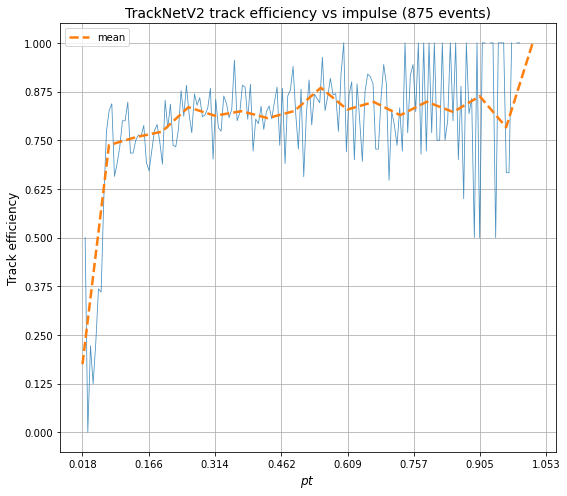

In [17]:
true_tracks_result_df = result_df[result_df.is_real_track == 1]
tracks_pred_true = true_tracks_result_df[true_tracks_result_df.found_right_point]
tracks_real = true_tracks_result_df[(true_tracks_result_df.found_right_point == False)  | (true_tracks_result_df.found_nothing==True)]
draw_for_col(true_tracks_result_df, tracks_pred_true, 'pt', '$pt$', 875, 175)

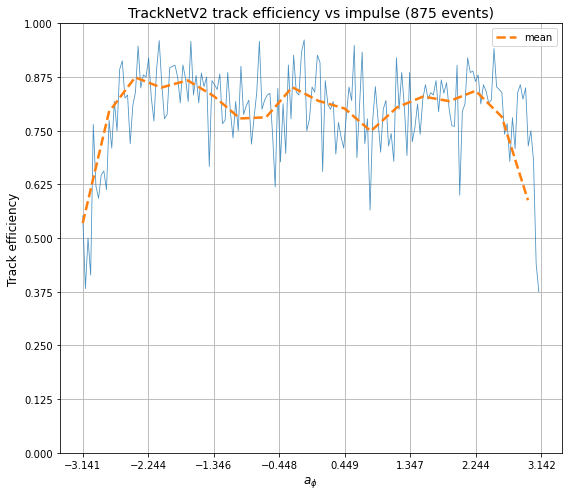

In [18]:
draw_for_col(true_tracks_result_df, tracks_pred_true, 'a_phi', '$a_\phi$',875,175)

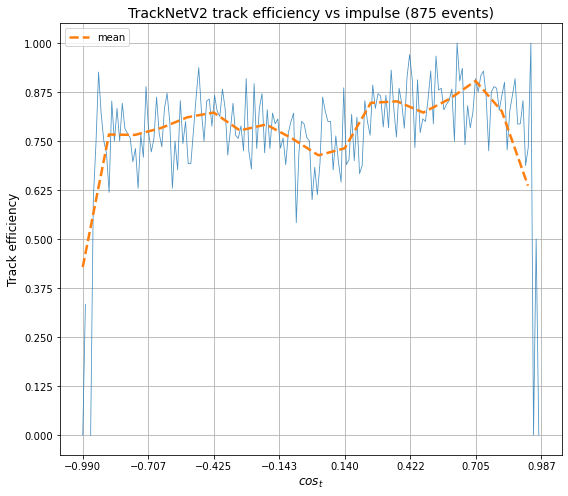

In [19]:
draw_for_col(true_tracks_result_df, tracks_pred_true, 'cos_t', '$cos_t$',875,175)